In [1]:
!pip install langchain_google_genai
!pip install langchain_core
!pip install langgraph
# !pip install langchain_openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 826.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.8 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.17 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 15.9 MB/s eta 0:00:00


In [2]:
# if using colab
from google.colab import userdata

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
# OPEN_AI_KEY = userdata.get('OPEN_AI_KEY')


In [ ]:
# if using notebook

!pip install python-dotenv
from dotenv import load_dotenv
import os

load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY is not found. Make sure it's set in .env file.")

print("API Key Loaded Successfully")  # Check if it loads

API Key Loaded Successfully


In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
# from langchain_openai import ChatOpenAI

llm = ChatGoogleGenerativeAI(
    model= "gemini-1.5-flash",
    api_key=GEMINI_API_KEY
)

# llm = ChatOpenAI(
#     model="gpt-4o",
#     api_key=OPEN_AI_KEY
#     )



In [4]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from typing import Dict, Optional

class FrontendState(MessagesState):

  is_greeting_route: bool = False
  name:str = None
  password:str = None

sys_msg = SystemMessage(content="""
      You are a frontend agent. a user message can be one of the following intents:
            1) Greeting (e.g., "hello", "hi")
            2) Store Intent (like user telling his/her personal information like name and password)
            3) Retrieve Intent (like asking for his/her personal information like name and password)

    You should respond according to the user message intent.
      - if it is greeting message then respond exactly with "It is a greeting."
      - if it is store intent then respond exactly with "store intent, name [name], password [password]"
      - if it is retrive intent then respond exactly with "It is a retrieve intent."
""")

def frontend_agent(state: FrontendState):
  print(state['messages'][-1])
  response = llm.invoke([sys_msg] + [state['messages'][-1]])
  state['messages'].append(response)

  if any(isinstance(m, AIMessage) and m.content == "It is a greeting." for m in state['messages']):
    state['is_greeting_route'] = True
    return state
  else:
    state['is_greeting_route'] = False

    return state



In [ ]:
import requests

try:
  response = requests.get("https://mermaid.ink", timeout=5)
  response.raise_for_status()  # Raises an exception if status code is not 200-299
  print("Mermaid.ink server is up and running.")
except requests.exceptions.RequestException as e:
  print(f"Mermaid.ink server might be down: {e}")

Mermaid.ink server is up and running.


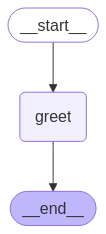

In [10]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
import graphviz


def greet(state: FrontendState):

  system_prompt = SystemMessage(content="""
  You are a friendly assistant responsible for handling user greetings.
- If the user says "hello", "hi", "hey", or any greeting, respond in a **warm and engaging way**.
- Example Responses:
  - "Hello there! How can I help you today?"
  - "Hey! Great to see you. What’s on your mind?"
  - "Hi! How can I assist you today?"
  """)

  # Call LLM to generate a response
  ai_response = llm.invoke([system_prompt] + state['messages'])

  # Append the generated AI response
  state['messages'].append(ai_response)

  return {"messages": state['messages']}

sub_graph_builder = StateGraph(FrontendState)
sub_graph_builder.add_node("greet", greet)
sub_graph_builder.add_edge(START, "greet")
sub_graph_builder.add_edge("greet", END)

greeting_subgraph = sub_graph_builder.compile()

display(Image(greeting_subgraph.get_graph(xray=True).draw_mermaid_png()))


In [6]:
def routing_function(state: FrontendState):
  if state['is_greeting_route']== False:
    return "user_preference_graph_agent"
  return "greeting_subgraph"

In [26]:
system_message = SystemMessage(content="""
    You are a user preference agent responsible for storing and retrieving the user's credentials.
    The frontend agent will provide one of two possible classifications:
    1️⃣
**Store Intent** (e.g., "store intent, name [name], password [password]"):
   - Extract the [name] and [password] from the message.
   - Store them in the conversation state (state['name'], state['password']).
   - Respond with a short confirmation that you have stored the name and the password.
   2️⃣
**Retrieve Intent** (e.g., "It is a retrieve intent."):
   - Check if state['name'] and state['password'] exist then respond with the values.
  #  - If they do, respond with their values.
   - If any credential does not exist, respond accordingly.
Be concise and clear in your final response.
""")

def user_preference_agent(state: FrontendState):
  if state['messages'][-1].content == "It is a retrieve intent.":
    response = llm.invoke([system_message] + state['messages'])
    state['messages'].append(response)
    return state
  else:
    response = llm.invoke([system_message] + state['messages'])
    state['messages'].append(response)

    # parts = response.content.split()

    parts = state['messages'][-2].content.split(", ")
    # Extract the name and password securely
    if len(parts) >= 2:
        extracted_name = parts[1].split("name ", 1)[1]  # First word = name
        extracted_password = parts[2].split("password ", 1)[1]  # Second word = password
    else:
        extracted_name = "Unknown"
        extracted_password = "Unknown"

    # Store them in the state (but keep the password private)
    state['name'] = extracted_name
    state['password'] = extracted_password
    print(state['name'])
    print(state['password'])

    # 5) Return the updated state (including the LLM's natural language response)
    return state


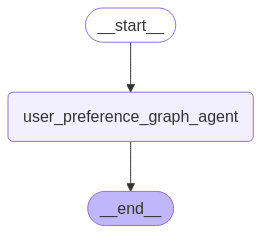

In [27]:
from langgraph.checkpoint.memory import MemorySaver

preference_graph_builder = StateGraph(FrontendState)
preference_graph_builder.add_node("user_preference_graph_agent", user_preference_agent)

preference_graph_builder.add_edge(START, "user_preference_graph_agent")
preference_graph_builder.add_edge("user_preference_graph_agent", END)

memory = MemorySaver()
user_preference_graph_agent = preference_graph_builder.compile(checkpointer=memory)

display(Image(user_preference_graph_agent.get_graph(xray=True).draw_mermaid_png()))

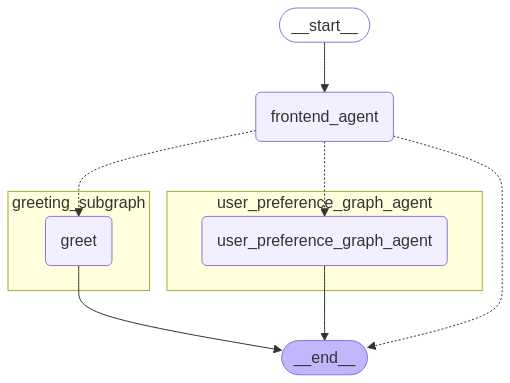

In [36]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver


builder = StateGraph(FrontendState)
builder.add_node("frontend_agent", frontend_agent)
builder.add_node("greeting_subgraph", greeting_subgraph)
builder.add_node("user_preference_graph_agent", user_preference_graph_agent)


builder.add_edge(START, "frontend_agent")
builder.add_conditional_edges("frontend_agent", routing_function)
builder.add_edge("greeting_subgraph", END)
builder.add_edge("user_preference_graph_agent", END)


# graph = builder.compile()


memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

display(Image(graph_memory.get_graph(xray=True).draw_mermaid_png()))



In [37]:
messages = [HumanMessage(content="my name is khazir and password is yahya1")]
thread_config = {"configurable": {"thread_id": "1"}}

messages1 = graph_memory.invoke({"messages": messages}, thread_config)

for m in messages1["messages"]:
  m.pretty_print()
print(messages1['name'])

content='my name is khazir and password is yahya1' additional_kwargs={} response_metadata={} id='b7a79e2b-2011-4ba4-b75e-ff8d7c9c0482'
khazir
yahya1
================================ Human Message =================================

my name is khazir and password is yahya1
================================== Ai Message ==================================

store intent, name khazir, password yahya1
================================== Ai Message ==================================

I have stored your name and password.
khazir


In [38]:
messages = [HumanMessage(content="what is my password ? ")]

messages1 = graph_memory.invoke({"messages": messages}, thread_config)

for m in messages1["messages"]:
  m.pretty_print()
# print(messages1['name'])

content='what is my password ? ' additional_kwargs={} response_metadata={} id='28c5e34c-46e9-49a0-a410-46d6fb893571'
================================ Human Message =================================

my name is khazir and password is yahya1
================================== Ai Message ==================================

store intent, name khazir, password yahya1
================================== Ai Message ==================================

I have stored your name and password.
================================ Human Message =================================

what is my password ? 
================================== Ai Message ==================================

It is a retrieve intent.
================================== Ai Message ==================================

Your password is yahya1.


In [39]:
messages = [HumanMessage(content="what is my name ? ")]

messages1 = graph_memory.invoke({"messages": messages}, thread_config)

for m in messages1["messages"]:
  m.pretty_print()

content='what is my name ? ' additional_kwargs={} response_metadata={} id='40447f06-8ca8-44cf-a009-3e24563a454d'
================================ Human Message =================================

my name is khazir and password is yahya1
================================== Ai Message ==================================

store intent, name khazir, password yahya1
================================== Ai Message ==================================

I have stored your name and password.
================================ Human Message =================================

what is my password ? 
================================== Ai Message ==================================

It is a retrieve intent.
================================== Ai Message ==================================

Your password is yahya1.
================================ Human Message =================================

what is my name ? 
================================== Ai Message ==================================

It is a retrieve 

In [40]:
messages = [HumanMessage(content="what is my name and password ? ")]

messages1 = graph_memory.invoke({"messages": messages}, thread_config)

for m in messages1["messages"]:
  m.pretty_print()

content='what is my name and password ? ' additional_kwargs={} response_metadata={} id='0211facc-41ab-4699-bd1f-7d3772377b64'
================================ Human Message =================================

my name is khazir and password is yahya1
================================== Ai Message ==================================

store intent, name khazir, password yahya1
================================== Ai Message ==================================

I have stored your name and password.
================================ Human Message =================================

what is my password ? 
================================== Ai Message ==================================

It is a retrieve intent.
================================== Ai Message ==================================

Your password is yahya1.
================================ Human Message =================================

what is my name ? 
================================== Ai Message ==================================

It i